In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from dowhy import CausalModel
from sklearn.linear_model import LinearRegression
from pathlib import Path
import os

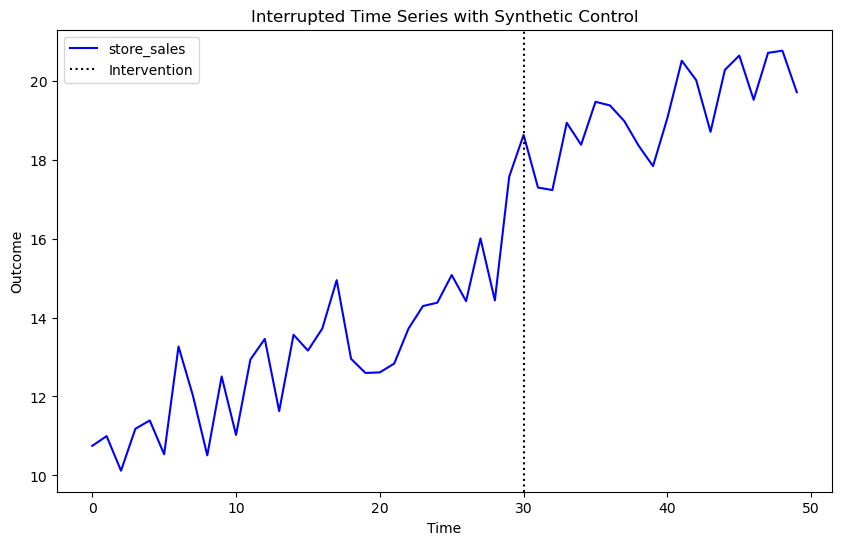

Estimated synthetic control weights (from OLS over pre-intervention):
competitor_sales    0.613812
online_sales        0.149392
market_average      0.261881
dtype: float64


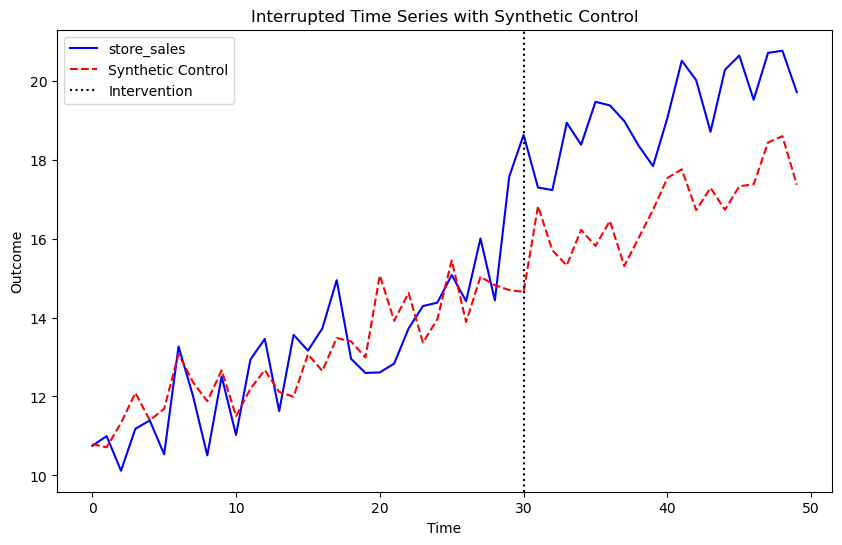

Estimated average treatment effect (post-intervention): 2.5097734011083963

Identified Estimand:
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                      
───────────────(E[store_sales|synthetic,time])
d[intervention]                               
Estimand assumption 1, Unconfoundedness: If U→{intervention} and U→store_sales then P(store_sales|intervention,synthetic,time,U) = P(store_sales|intervention,synthetic,time)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}

DoWhy estimated effect (coefficient for the intervention): 2.169890711815947


/Users/fabioyamada/miniconda3/envs/.causal_inference/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from dowhy import CausalModel

# Set random seed for reproducibility
np.random.seed(42)

# Define time periods and the intervention timing
T = 50                        # Total number of time points
intervention_time = 30        # Intervention occurs at time=30
time = np.arange(T)

# -------------------------------
# Generate Synthetic Data
# -------------------------------
# Simulate three control time series with a common linear trend plus noise
competitor_sales = 10 + 0.15 * time + np.random.normal(0, 1, T)
online_sales = 12 + 0.14 * time + np.random.normal(0, 1, T)
market_average = 11 + 0.16 * time + np.random.normal(0, 1, T)

# Create a store_sales time series that follows a similar pre-intervention trend as controls
store_sales = 10.5 + 0.15 * time + np.random.normal(0, 1, T)
# Introduce a treatment effect in the post-intervention period (e.g., a level shift)
store_sales[intervention_time:] += 3

# Build a pandas DataFrame with all series
df = pd.DataFrame({
    'time': time,                           # Time periods as weeks (e.g., week 1 to week 50)
    'store_sales': store_sales,             # Weekly sales ($000s) for the store_sales store
    'competitor_sales': competitor_sales,   # Weekly sales ($000s) for a nearby competitor store
    'online_sales': online_sales,           # Weekly sales ($000s) from the company's online channel
    'market_average': market_average        # Weekly average sales ($000s) across similar stores in the market
})


plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['store_sales'], label='store_sales', color='blue')
plt.axvline(x=intervention_time, color='k', linestyle=':', label='Intervention')
plt.xlabel("Time")
plt.ylabel("Outcome")
plt.title("Interrupted Time Series with Synthetic Control")
plt.legend()
plt.show()

# -------------------------------
# Synthetic Control Construction
# -------------------------------
# For the pre-intervention period, we want to find weights on control units that best approximate the store_sales series.
pre_mask = df['time'] < intervention_time  # Pre-intervention indicator

# Set up predictors (controls) and response (store_sales) using pre-intervention data
X_pre = df.loc[
    pre_mask,
    ['competitor_sales', 'online_sales', 'market_average']
]
y_pre = df.loc[pre_mask, 'store_sales']

# Fit an OLS regression on the pre-intervention period
model_ols = sm.OLS(y_pre, X_pre).fit()
weights = model_ols.params
print("Estimated synthetic control weights (from OLS over pre-intervention):")
print(weights)

# Create the synthetic control series for the full period by taking a weighted combination of controls
df['synthetic'] = df[
    ['competitor_sales', 'online_sales', 'market_average']
].dot(weights)

# -------------------------------
# Visualize the Results
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['store_sales'], label='store_sales', color='blue')
plt.plot(df['time'], df['synthetic'], label='Synthetic Control', color='red', linestyle='--')
plt.axvline(x=intervention_time, color='k', linestyle=':', label='Intervention')
plt.xlabel("Time")
plt.ylabel("Outcome")
plt.title("Interrupted Time Series with Synthetic Control")
plt.legend()
plt.show()

# Calculate and report the average treatment effect in the post-intervention period
post_mask = df['time'] >= intervention_time  # Post-intervention indicator
treatment_effect = df.loc[post_mask, 'store_sales'] - df.loc[post_mask, 'synthetic']
print("Estimated average treatment effect (post-intervention):", treatment_effect.mean())

# -------------------------------
# Causal Inference with DoWhy
# -------------------------------
# Create an indicator variable for the intervention (0 for pre, 1 for post)
df['intervention'] = (df['time'] >= intervention_time).astype(int)

# Here, we use DoWhy to define a causal model.
# In this simple specification, we treat the intervention indicator as the treatment,
# the observed outcome is from the store_sales unit, and we include 'time' and the synthetic control
# series as additional covariates to adjust for time-varying confounding.
model = CausalModel(
    data=df,
    treatment='intervention',
    outcome='store_sales',
    common_causes=['time', 'synthetic']
)

# Identify the causal estimand using backdoor criteria
identified_estimand = model.identify_effect()
print("\nIdentified Estimand:")
print(identified_estimand)

# Estimate the treatment effect using linear regression (a backdoor adjustment method)
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("\nDoWhy estimated effect (coefficient for the intervention):", estimate.value)


# Interpreting the Interrupted Time Series with Synthetic Control Results

Let me break down the results from your causal inference analysis in clear terms:

## The Treatment Effect

**Estimated average treatment effect (post-intervention): 2.51**

This means that after the intervention (which occurred at time=30), the store_sales unit's outcome was approximately 2.51 units higher on average than what would have happened without the intervention (as estimated by the synthetic control).

Think of this like comparing your actual weight loss after starting a new diet (store_sales series) versus what your weight would have been if you hadn't changed your eating habits (synthetic control). The difference—2.51 pounds in this analogy—represents the causal effect of the diet.

## DoWhy's Causal Analysis

### Identified Estimand

The output shows that DoWhy successfully identified a "backdoor" estimand for estimating the causal effect. This is like finding a valid way to calculate the effect by controlling for confounding factors.

The mathematical expression `d/d[intervention](E[store_sales|time,synthetic])` represents how the expected value of the store_sales outcome changes when the intervention status changes, while holding time and the synthetic control constant.

### Unconfoundedness Assumption

The key assumption stated is that if there are any unmeasured factors (U) affecting both the intervention and the outcome, then conditioning on time and the synthetic control is sufficient to remove this confounding.

This is similar to saying: "If we know what day it is and what would have happened without the intervention (synthetic control), then any other factors that might influence both when the intervention happened and the outcome are already accounted for."

### DoWhy Estimated Effect

**DoWhy estimated effect: 2.17**

This value (2.17) is slightly different from the direct calculation (2.51) because DoWhy uses a linear regression model that explicitly controls for time and the synthetic control series. 

Think of it like this: if two methods for calculating your diet's effectiveness give similar results (2.51 vs 2.17 pounds lost), you can be more confident in concluding that the diet actually worked.

## Practical Interpretation

In business terms, this could represent:
- A marketing campaign that increased sales by 2.5 units per day
- A website redesign that improved conversion rates by 2.5 percentage points
- A pricing change that increased revenue by $2.5 million

The fact that both estimation methods (direct comparison and DoWhy's regression approach) yield similar results strengthens the evidence that the observed effect is real and not just due to chance or confounding factors.

The slight difference between the two estimates (2.51 vs 2.17) suggests there might be some time-varying factors that the simple difference doesn't fully account for, but which the regression model helps to address.

## Analogy for the Entire Analysis

Think of this analysis like a scientific experiment where you can't have a true control group:

1. You have a patient (store_sales unit) who takes a new medication at day 30
2. You don't have an identical twin to serve as a control
3. So you create a "synthetic twin" by combining data from similar patients (control units)
4. You carefully match the synthetic twin to mirror the patient's pre-medication health metrics
5. After the medication starts, you observe that the real patient's health improved by 2.5 points compared to the synthetic twin
6. You verify this finding using a statistical model that accounts for natural trends and other factors

The analysis suggests that the medication (intervention) caused the 2.5-point improvement, rather than other factors that would have affected both the real patient and the synthetic twin.

---

In [43]:
# path = os.path.join(os.getcwd(), 'video_data/1_interrupted_time_series_synthetic_control/data.csv')
# df.to_csv(path, index=False)

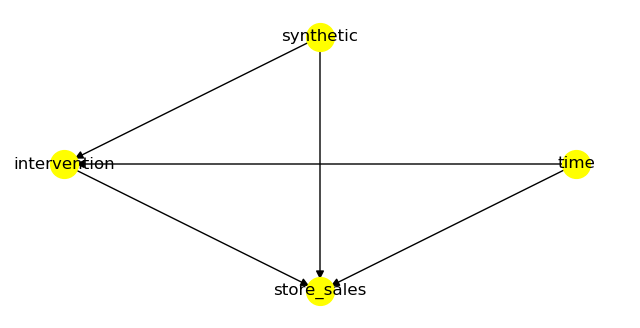

In [44]:
model.view_model(size=(8, 4))

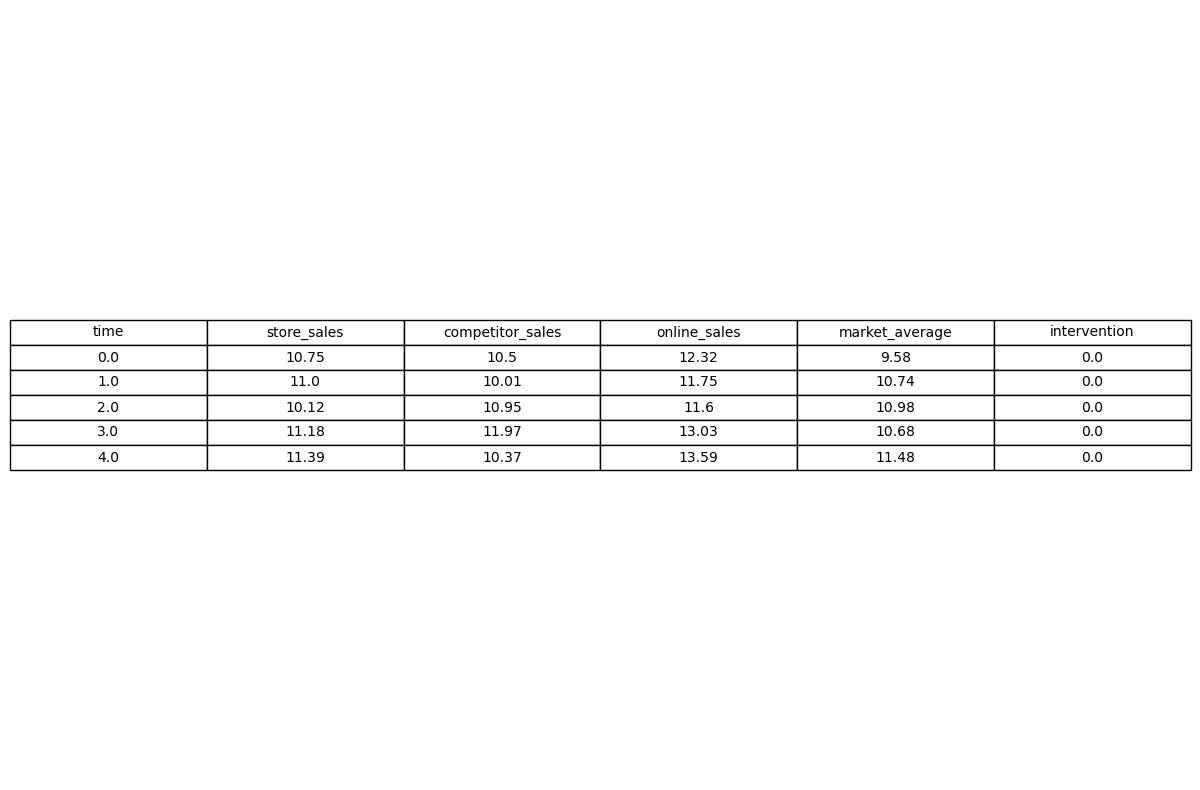

In [45]:
fig, ax = plt.subplots(figsize=(12,8)) #Adjust figure size to fit the screen

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

# Round the values to 2 decimal places
cell_text = np.round(df.drop(columns='synthetic').head().values, 2)

# Create the table
table = ax.table(cellText=cell_text, colLabels=df.drop(columns='synthetic').head().columns, loc='center')

# Modify cells to center the text
for (row, col), cell in table.get_celld().items():
    if row > 0:  # Exclude header row
        cell.set_text_props(ha='center', va='center')

table.auto_set_font_size(False)
table.set_fontsize(10)  # Adjust font size if needed
table.scale(1.2, 1.2)  # Adjust the table size

fig.tight_layout()

plt.show()

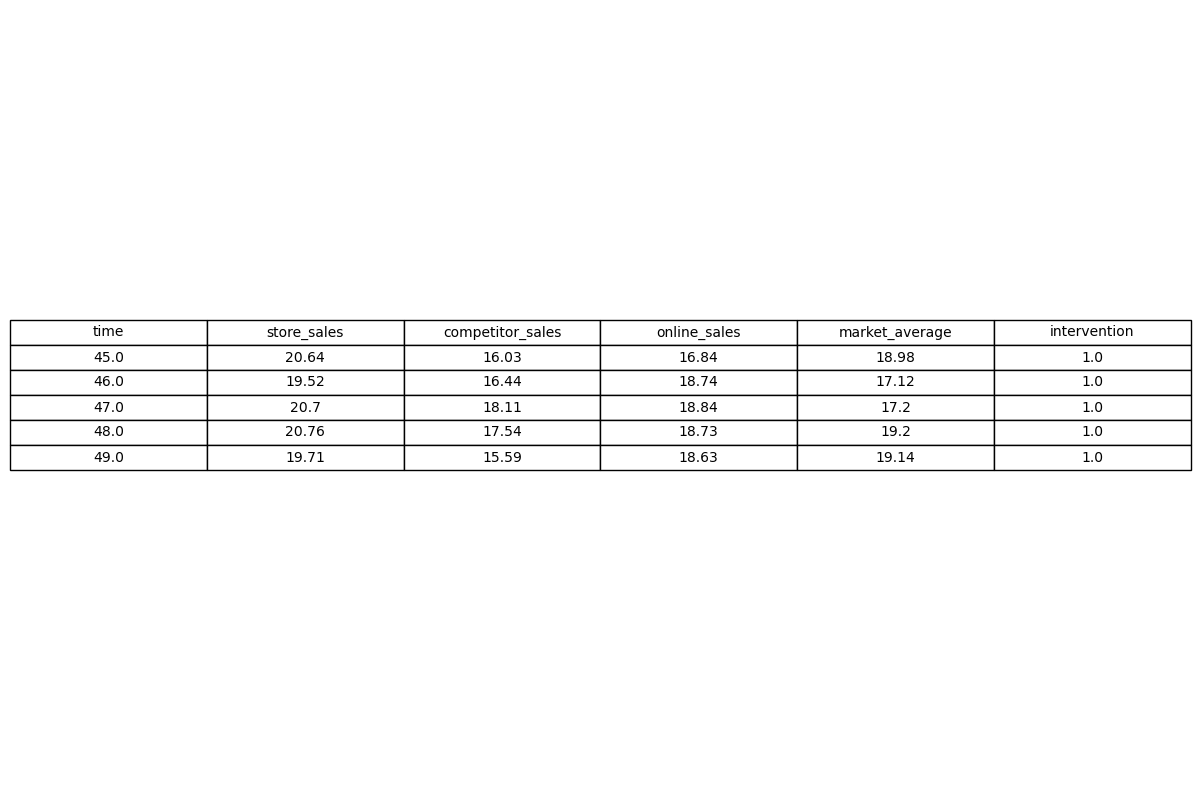

In [46]:
fig, ax = plt.subplots(figsize=(12,8)) #Adjust figure size to fit the screen

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

# Round the values to 2 decimal places
cell_text = np.round(df.drop(columns='synthetic').tail().values, 2)

# Create the table
table = ax.table(cellText=cell_text, colLabels=df.drop(columns='synthetic').head().columns, loc='center')

# Modify cells to center the text
for (row, col), cell in table.get_celld().items():
    if row > 0:  # Exclude header row
        cell.set_text_props(ha='center', va='center')

table.auto_set_font_size(False)
table.set_fontsize(10)  # Adjust font size if needed
table.scale(1.2, 1.2)  # Adjust the table size

fig.tight_layout()

plt.show()

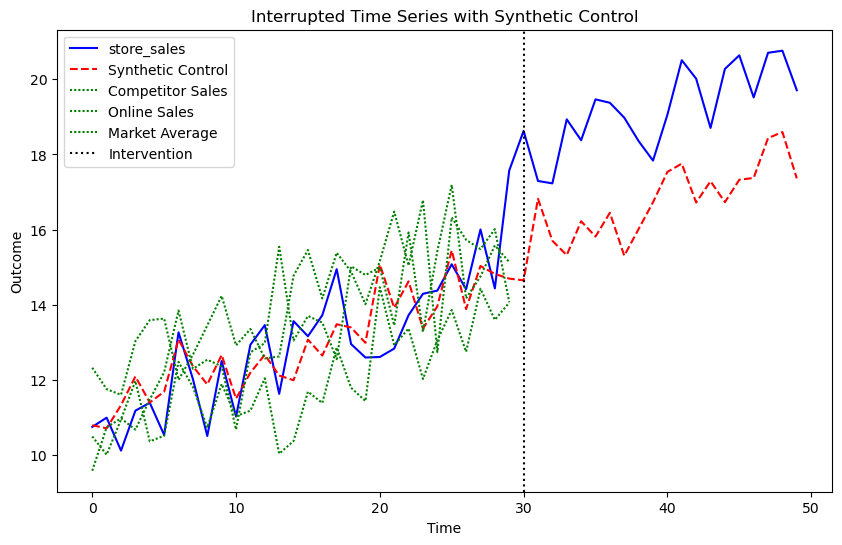

In [47]:
'competitor_sales'
'online_sales'
'market_average'
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['store_sales'], label='store_sales', color='blue')
plt.plot(df['time'], df['synthetic'], label='Synthetic Control', color='red', linestyle='--')
plt.plot(df.query('intervention == 0')['time'], df.query('intervention == 0')['competitor_sales'], label='Competitor Sales', color='green', linestyle=(0, (1, 1)))
plt.plot(df.query('intervention == 0')['time'], df.query('intervention == 0')['online_sales'], label='Online Sales', color='green', linestyle=(0, (1, 1)))
plt.plot(df.query('intervention == 0')['time'], df.query('intervention == 0')['market_average'], label='Market Average', color='green', linestyle=(0, (1, 1)))
plt.axvline(x=intervention_time, color='k', linestyle=':', label='Intervention')
plt.xlabel("Time")
plt.ylabel("Outcome")
plt.title("Interrupted Time Series with Synthetic Control")
plt.legend()
plt.show()